# Homecenters en Bogotá

En Bogotá hay 8 Homecenters:

|   |      Nombre      |                     Dirección                     |       Coordenadas       |
|---|:----------------:|:-------------------------------------------------:|:-----------------------:|
| 1 |     Calle 80     |                  Ak 68 # 80 - 77                  |  [4.685041,-74.0811259] |
| 2 |     Calle 170    |              Autopista Nte. #175 - 50             |  [4.755462,-74.0492417] |
| 3 |  Avenida 68 sur  |                 Cra 68 # 37-37 Sur                |  [4.604073,-74.1324518] |
| 4 |      Dorado      |                 Calle 50 # 82 - 55                |  [4.679019,-74.1178289] |
| 5 | CC Mallplaza NQS |                  Cl. 19 # 28 - 80                 |  [4.618953,-74.0887638] |
| 6 |     Cedritos     |                 Ak. 9 # 152a - 23                 |  [4.730568,-74.0349332] |
| 7 |       Suba       |           Avenida Carrera 104 # 148 - 07          |  [4.751429,-74.0949194] |
| 8 |      Tintal      |                Calle 10B # 86 - 50                |  [4.6515264,-74.148429] |
| 9 | Soacha CC Mercurio  |        Cra. 7 # 32 - 35 Local 108       |  [4.588613,-74.205057] |
| 10 | Cajica  |        Km 27 Vía Chía - Cajicá       |  [4.8921433,-74.0346673] |


In [21]:
import requests
from sklearn.cluster import KMeans
from shapely.geometry import Polygon, Point

# Se crea la función que genera poligonos de cobertura a partir de coordenadas
def isolineGeneration(lat:float, lng: float, cov_type: str, value: float):
    
    coordinates = 'geo!' + str(lat) + ',' + str(lng)
    api_structure = 'https://isoline.route.ls.hereapi.com/routing/7.2/calculateisoline.json'
    payload = {
    		'apiKey' : 'A6oKk5QyLYkxJ4efaUoDQZjjRNQ2bibTpYA2SE0oxiM',
    		'start' : coordinates,
            'range': value,
            'rangetype':cov_type,
            'mode': 'shortest;car;traffic:disabled'
        }
    response=requests.get(api_structure, params=payload)
    response=response.json()
    polygon = response['response']['isoline'][0]['component'][0]['shape']
    
    listPoints = []
    for i in polygon:
        coors = i.split(",")
        listPoints.append([ float(coors[1]), float(coors[0])])
    
    return listPoints

In [22]:
# Función que determina si un punto está dentro de un polígono
def inside(polygon, lat: float, lng: float):
    
    # El poligono tiene puntos de lng,lat
    testPoint = Point(lng, lat)
    
    # Si el punto está en la cobertura no pasa nada, de lo contrario se borra
    if polygon.contains(testPoint):
        return True
    else:
        return False

In [23]:
import json
import pandas as pd
# Se leen los datos de clientes y de ubicaciones de Homecenter
clients = pd.read_csv('clients.csv', index_col = 'id').fillna(0).to_dict(orient = 'index')

with open('homecenters.json', 'r') as fp:
    homecenters = json.load(fp)

In [24]:
# Se crean los poligonos de cobertura a 15mins en carro y se verifican que clientes están dentro
for i in homecenters:
    homecenters[i]['polygon'] = isolineGeneration(homecenters[i]['lat'], homecenters[i]['lng'], 'time', 400)
    homecenters[i]['clients'] = []
    for j in clients:
        if inside(Polygon(homecenters[i]['polygon']), clients[j]['lat'], clients[j]['lng']):
            homecenters[i]['clients'].append(clients[j]) 

In [25]:
# Se crea un archivo json con los poligonos para graficarlos

jsonOut = {"type": "FeatureCollection", "name": "Homecenters Bogota", "features": []}

for i in homecenters:
    jsonOut['features'].append({"type": "Feature", 
                                "properties": {"name": i},
                                "geometry": {
                                    "type": "Polygon",
                                    "coordinates": [homecenters[i]['polygon']]
                                }})

with open('HC_Polygons.json', 'w') as fp:
    json.dump(jsonOut, fp)

# Resultados

Ahora se analizan los datos obtenidos.

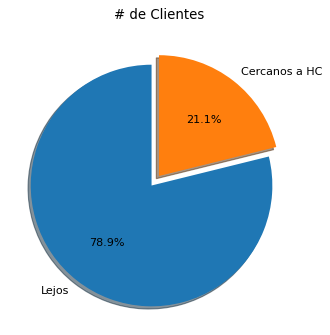

In [39]:
import matplotlib.pyplot as plt

# Número de clientes totales en el Universo y # de clientes cercanos a Homecenters
plt.figure(figsize=(14, 5), dpi=80)
labels = ['Lejos', 'Cercanos a HC']
sizes = [len(clients)-sum([len(homecenters[i]['clients']) for i in homecenters]), 
         sum([len(homecenters[i]['clients']) for i in homecenters])]
explode = (0.1, 0)

plt.pie(sizes, explode = explode, labels = labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('# de Clientes')
plt.show()

Calle 80 125 79 2050780722.1259418
Calle 170 35 50 415113074.8221037
Avenida 68 sur 59 59 1410041417.324928
Dorado 53 41 1693238780.0831401
CC Mallplaza NQS 140 90 2514395159.6811414
Cedritos 59 67 589188249.5049729
Suba 82 86 1104190627.2928374
Tintal 20 23 781536353.4559418
Soacha CC Mercurio 52 91 1358846427.4362218
Cajica 1 0 0.0


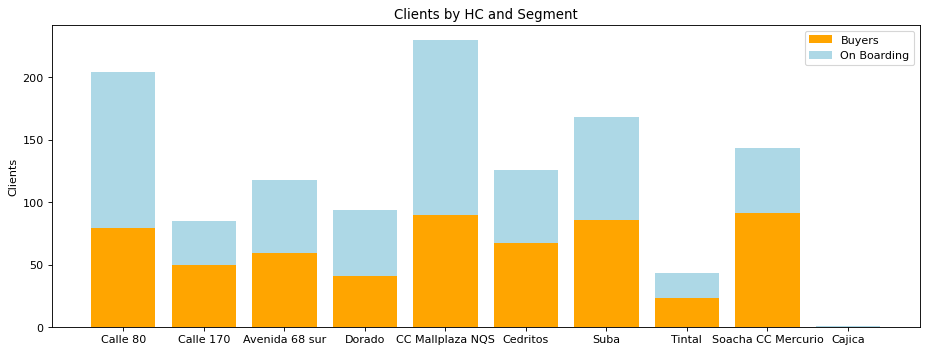

In [38]:
# Se calcula el numero de clientes para cada homecenter:
plt.figure(figsize=(14, 5), dpi=80)
y1, y2, y3, l = [],[],[],[i for i in homecenters]
for i in homecenters:
    noBuyers = 0
    Buyers = 0
    total = 0
    for j in homecenters[i]['clients']:
        total += j['acum_total']
        if j['segment'] == 'on boarding':
            noBuyers += 1
        else: Buyers += 1
    y1.append(noBuyers)
    y2.append(Buyers)
    y3.append(total)
    print(i, noBuyers, Buyers, total)
plt.bar(l, y2, label = 'Buyers', color = 'orange')
plt.bar(l, y1, label = 'On Boarding', color = 'lightblue', bottom=y2)

plt.ylabel('Clients')
plt.title('Clients by HC and Segment')
plt.legend()